In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython import nominal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [3]:
df_logins = pd.read_json('logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [10]:
df_logins.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648247
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


# Part 1 - Exploratory Data Analysis

In [47]:
# aggregate login counts based on 15 min time intervals
df_logins.set_index('login_time')
df_logins['login_count'] = 1.0
df_15min = df_logins.resample('15min', on='login_time').sum()
df_15min.head()

,login_count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [29]:
df_15min.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [32]:
# check for null values
df_15min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   login_count  9788 non-null   float64
dtypes: float64(1)
memory usage: 152.9 KB


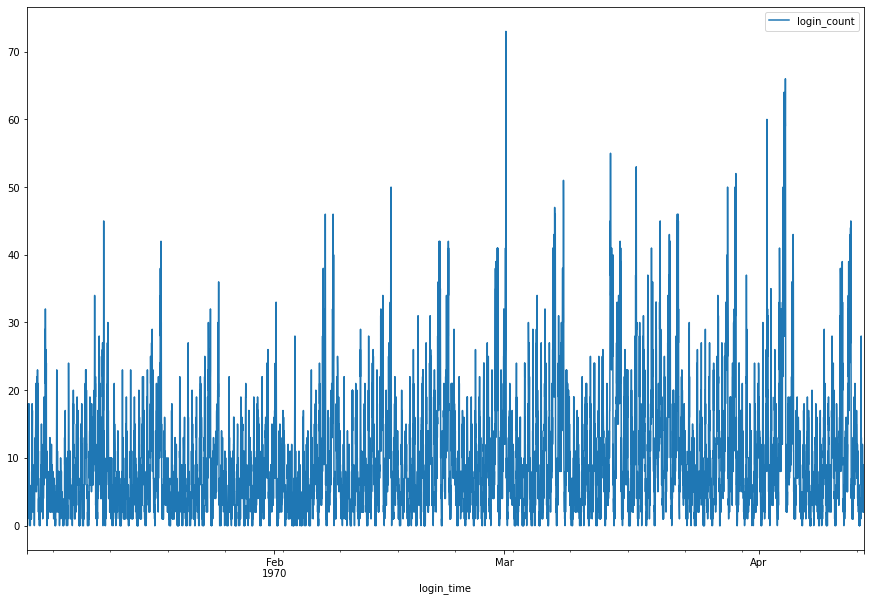

In [42]:
# plot the counts
df_15min.plot(figsize=(15,10));

The time series potentially exhibits some periodicity and is potentially stationary

The days might potentially see more logins around midnight and noon

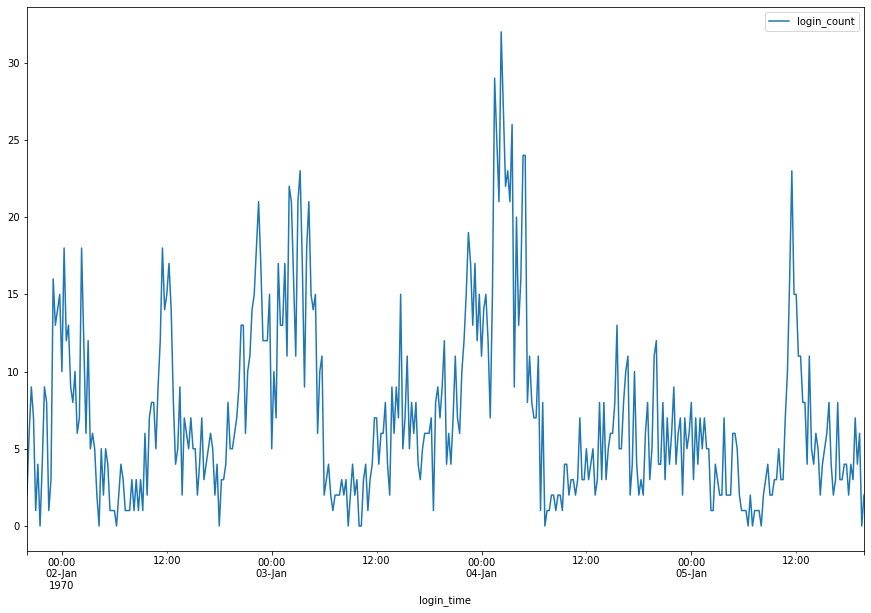

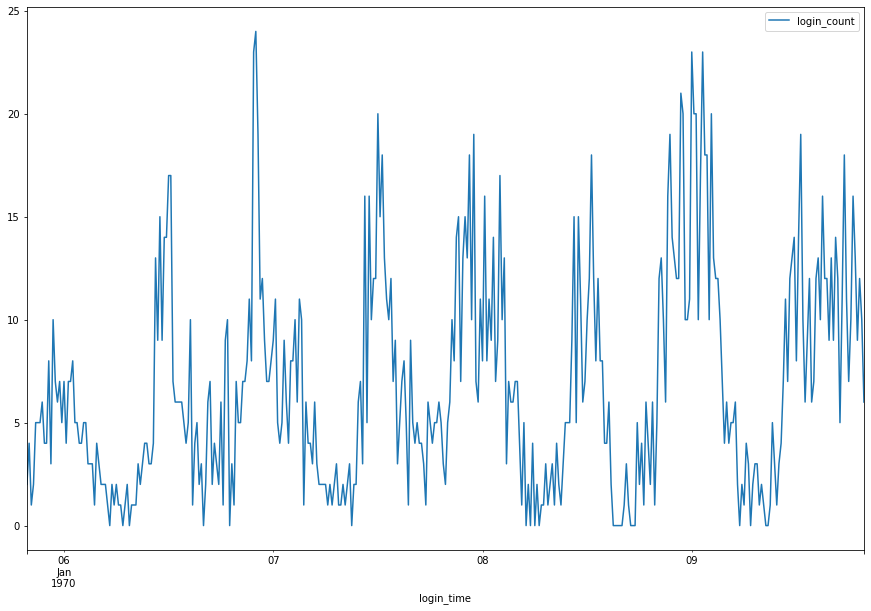

In [57]:
#plot first 8 days in two plots
df_15min.iloc[0:384].plot(figsize=(15,10));
df_15min.iloc[383:768].plot(figsize=(15,10));

There appear to be peaks around midnight and noon each day

In [ ]:
# rides taken by day 




# Part 2 - Experiment and Metrics Design

<p style= "font-family: Times ; font-size: 18px">
Key measures of success: 
<br> I would look at the increase in partner engagement in the other city on weekdays and weekends separately. Since the two cities both have a fair amount of activity on the weekend, there might not be as much incentive for partners to cross ciies. On the weekdays, however, the cities have different patterns, so partners might have more incentive to work in the other city when their city is not active. I would also look at whether there was an increase in trips between the two cities. <br>
In summary: <br>
1) Proportion of a driver's trips in their main city and the other city on weekdays<br>
2) Proportion of a driver's trips in their main city and the other city on weekends<br>
3) Increase in trips between the two cities
        
<p style= "font-family: Times ; font-size: 18px">
Experiment design:<br>
To test whether or not the new policy impacts the partners' presence in both cities, I'd design an experiment following a set of drivers from both cities using the following steps: <br>
1) Randomly select a set of drivers from each city. The number selected would be dependent on the resources available for this experiment. If it is possible to track every driver, this is optimal. If not, make sure to have either a similar size group from each city or a similar proportion of total drivers, depending on the total number of drivers in each city. <br>
2) Track the drivers' activity for two weeks before the new toll policy is implemented. Note that I would not recommend the two weeks right before the new policy is implemented, as driver behavior might begin changing in preparation for the new policy. <br>
3) Track the drivers' activity for two weeks after the new policy is implemented. Note that I would not recommend tracking the two weeks immediately after the policy is implemented, as driver behavior is likely to still be adapting to the new policy. <br>
4) Calculate the proportions of trips in the drivers' main cities vs the other city on weekdays and weekends and the amount of trips that took place between the two cities. <br>
5) With 0 change in proportionss as the null hypothesis, conduct a two-tailed hypothesis testing with alpha = 0.05 to determine if there is a significant difference in trips taken in different cities after the policy was implemented. While we are most interested in increasing trips, it is worth conducting a two-tailed test to determine if the policy has actually decreased trips in different cities instead. 

# Part 3 - Predictive Modeling

In [5]:
users = pd.read_json('ultimate_data_challenge.json')
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


<p style= "font-family: Times ; font-size: 18px">
There are some null values for average rating of driver, phone type, and average rating by driver. However, there are not a huge amount in phone or average rating by driver. Average rating of driver has 8,000 null values, but this is likely due to riders simply not rating their driver, and we still have nearly 42,000 records. <br>
    There are not any null values in the columns we will need to calculate retention rate. 

In [13]:
# convert signup_date and last_trip_date to datetime 
users['signup_date'] = pd.to_datetime(users['signup_date'])
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [15]:
# find users active in the last 30 days

#find last data point
users['last_trip_date'].sort_values(ascending=False).head(5)

45357   2014-07-01
22735   2014-07-01
14473   2014-07-01
38651   2014-07-01
45126   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

In [19]:
# create column for active users
last_30 = pd.to_datetime('2014-06-01')
users['retained'] = users['last_trip_date'].apply(lambda x: 1 if x >= last_30 else 0)
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [28]:
# find retention rate
retention = users['retained'].sum() / users['retained'].count()
print("The retention rate is", round(100*retention, 2), "%.")

The retention rate is 37.61 %.


### Build a predictive model to determine whether or not a user will be active in their 6th month on the system


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  retained                50000 non-null  int64 

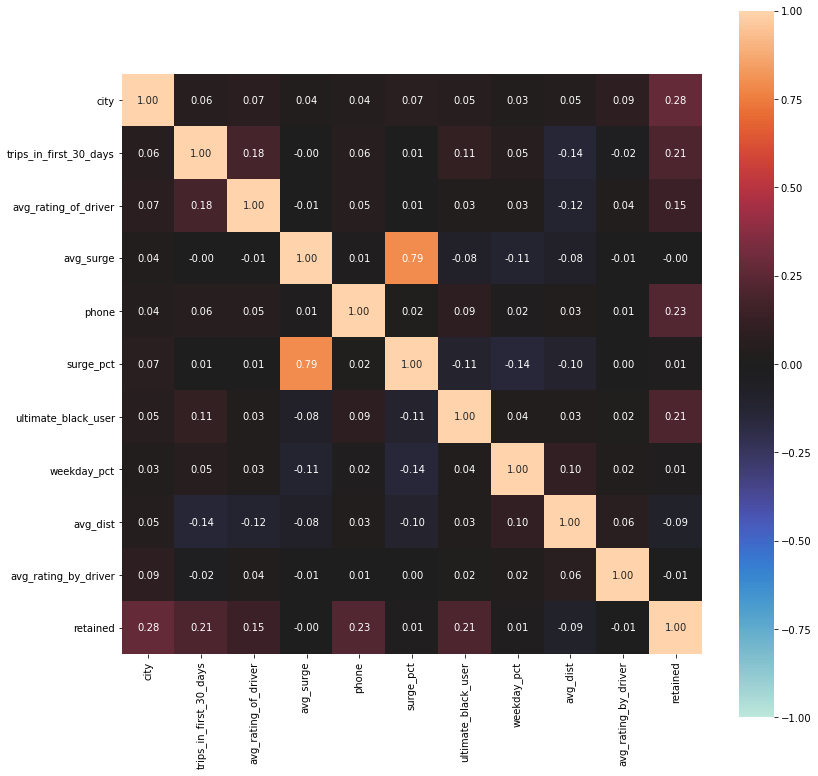

In [38]:
# drop datetime columns as we no longer need them
users.drop(columns=['signup_date','last_trip_date'], inplace=True)

# heat map for an overview of variable relationships

fig, ax = plt.subplots(figsize=(13, 13))
nominal.associations(users, nominal_columns=['city','phone'], ax=ax);

<p style= "font-family: Times ; font-size: 18px">
    There aren't any strong correlations that immediately jump out, other than the correlation between avg_surge and surge_pct, which are related variables. These two variables have similar correlations across the board. I will only use the surg_pct variable.<br> 
    City, phone type, number of trips in the first 30 days, and whether a user is an Ultimate Black user appear to have the strongest correlation with retention, but still only around .2 to .3.

In [45]:
# get dummy variables
users_dum = pd.get_dummies(users)
users_dum['ultimate_black_user'] = users_dum['ultimate_black_user'].astype(int)
users_dum.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_0.0,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,0,1,0


<p style= "font-family: Times ; font-size: 18px">
As this is a binary classification problem regarding customer retention, I will use a logistic regression model. Alternate approaches include KNN, SVM, and decision trees. 

In [66]:
# define variables
X = users_dum.drop(columns=['retained','avg_surge'])
y = users['retained']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=16)

# initiate model 
reg = LogisticRegression(max_iter=500, random_state=16)

# Fit the model 
reg.fit(X_train, y_train)

#predict
y_pred = reg.predict(X_test)

In [74]:
# evaluate model 
print("The f1 score is:",f1_score(y_test, y_pred))
print("The precision score is:",precision_score(y_test, y_pred))
print("The recall score is:",recall_score(y_test, y_pred))

The f1 score is: 0.5724208375893769
The precision score is: 0.6777939042089985
The recall score is: 0.4954031117397454


<p style= "font-family: Times ; font-size: 18px">
This model is correct in approximately 68% of cases when it predicts a customer as retained (precision). The model struggles more to identify all retained customers, correctly predicting only 50% of truly retained customers (recall). Which metric is more important depends on the decisions being made with this information. The stated goal is to "predict retention", and, without more specifics, I will focus on revenue. If we are trying to predict retention to look at revenue implications, precision is the more important metric: it would be worse to predict a customer as retained when they are not than to predict a customer as not retained when they are. 

Confusion matrix without normalization
[[8012 1332]
 [2854 2802]]
Normalized confusion matrix
[[0.85744863 0.14255137]
 [0.50459689 0.49540311]]


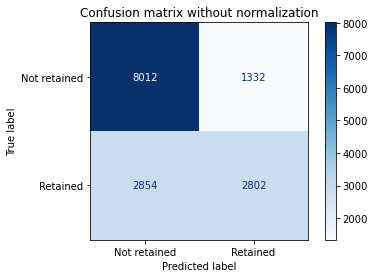

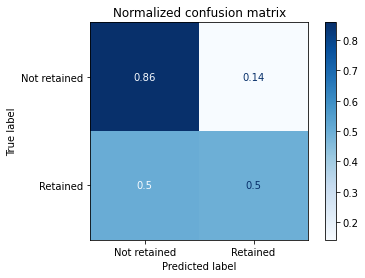

In [73]:
# Plot confusion matrix
titles_options = [("Confusion matrix without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(reg, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 display_labels=['Not retained', 'Retained'],
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show();

In [133]:
# feature importance
coefs = reg.coef_
coefs = coefs.flatten()
labels = X.columns
features = pd.DataFrame({'features':labels, 'coefs':coefs})
features.head()

,features,coefs
0,trips_in_first_30_days,0.109433
1,avg_rating_of_driver,0.124152
2,surge_pct,0.002263
3,ultimate_black_user,0.883942
4,weekday_pct,-0.000396


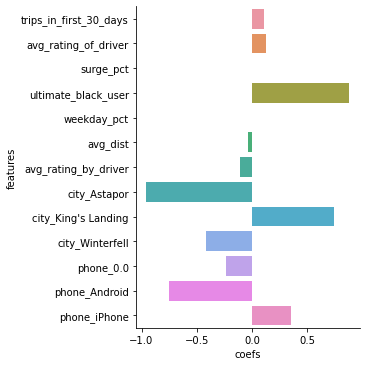

In [142]:
ax = sns.catplot(x="coefs",y="features",kind="bar", data=features)

<p style= "font-family: Times ; font-size: 18px">
    The features that have the most impact on user retention appear to be whether or not a user is an Ultimate Black customer, the type of phone they use, and their city of origin. Interestingly, being from King's Landing is a positive for retention, while being from Astapor or Winterfell is a negative. Being an Android user is also negative for retention. <br><br>
    The model indicates that Ultimate has a couple areas to explore to improve customer retention. <br>
    1) The model indicates that there might be a problem with the user experience on Android phones. Examine user experience on Android phones. Is the app working well, or does it have more problems on Androids than iPhones? Is the user interface vastly different? What else is different for users between Androids and iPhones that could be impacting user retention? <br>
    2) What is the difference between King's Landing and the other two cities, Astapor and Winterfell? Perhaps Ultimate does not advertise well in Astapor and Winterfell, perhaps Astapor and Winterfell have more transportation options that King's Landing, so Ultimate has more competitors, etc. If Ultimate can identify important differences between the cities, they can address the Astapor and Winterfell customers better. 